In [1]:
from covbind_esm2_struct import CovBind_ftESM as esm2_struct 
from covbind_esm2_struct import SequenceDataset as esm2_struct_dataset

In [42]:
import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd 
import matplotlib.pyplot as plt


import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [23]:
model_savepath = 'saved_models/covbind_ESM2_Struct_ft.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 
model = model.eval() 

/Users/faisal/_RESEARCH/__Ongoing/CovAbDab/covbind_esm2_struct.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vh_model.load_state_dict(torch.load('Pretrained/ESM2

In [8]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_struct_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

/Users/faisal/_RESEARCH/__Ongoing/CovAbDab/covbind_esm2_struct.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.tg_embs = torch.load('data/target_embeddings.pt')


In [16]:
cond1 = (df_test['Binding']==1) & (df_test['Neutralizing']==0)
cond2 = (df_test['Binding']==1) & (df_test['Neutralizing']==1)
cond3 = (df_test['Target']=="sars-cov2-omicron-ba2") 

In [20]:
df1 = df_test[cond1 & cond3] 

In [31]:
df1['Antibody VH'].tolist() 

['QVQLVQSGGALVQPGGSLSLSCLVSGFIFSDYSMHWVRQAPGKGLDYVSGISSTGDITDYADSVKDRFTISRDNSKNMLYLQMSSLRVEDTAVYYCVKDIGSWKYFDVFDVWGQGTTVTVSS',
 'QVQLVQSGGGVVQPGRSLRLSCEASGFTFSNYGMHWVRQAPGKGLEWVAVIWDDGSGKHYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDGPGDKMVTLFDYWGQGTLVTVSS',
 'QVQLVQSGGGLVRPGGSLRLSCAASEITVSSNYMNWVRQAPGKGLEWVSVIYAGGSTFYADSVKGRFSISRDNSKNTLYLQMNSLRADDTAVYYCARDLGPYGFDIWGQGTTVTVSS',
 'QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYSISWVRQAPGQGPEWLGKILPILGATDYAQKFQGRVTIIADKSTSTAYMELSSLRSEDTAVYYCARESGYSGSGSVTYFHLWGRGTLVTVSS',
 'EVKLEESGGGLVQPGGSMKLSCAASGFTFSDAWMDWVRQSPEKGLEWVAQIRRKANNHATYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCIRGMTYAMDFWGQGTSVTVSS',
 'VQLVESGGGLVQPGGSLRLSCAASGFTFSSYDMHWVRQTTGKGLEWVSTIGTAGDTYYPDSVKGRFTISREDAKNSLYLQMNSLRAGDTAVYYCARGDSSGYYYYFDYWGQGTLLTVSS',
 'EVQLVQSGAEVKKPGESLKISCKHSGYSLTSYWIGWVRQMPGKGLEWMGIIFPGDSDTRYSPSFQGHVTISADKSITTAYLQWASLKASDTAMYYCARLPGLGELSSHFDYWGQGTRVTVSS',
 'QVQLVQSGAEVKKPGASVKVSCRASGYTFTAYYLHWVRQAPGQGLEWMGWINPDSGDTNYAQTFQGRVTMTRDTSITTAYMELSRLTSDDTAVYYCARDLSALGPSYADDNAFDIWGQ

In [21]:
df2 = df_test[cond2 & cond3] 

In [36]:
def get_vh_vl_attentions(df1):
    dataset_test = esm2_struct_dataset(df1['Antibody VH'].tolist(), 
                            df1['Antibody VL'].tolist(),
                            df1['Target'].tolist(),
                            df1['Binding'].tolist())
    data_loader = DataLoader(dataset_test, batch_size=8, shuffle=True)

    vh_attns = []   
    vl_attns = []   
    with torch.no_grad():
        for vh_ids,  vl_ids, ag_embs, labels in data_loader:
            vh_ids = vh_ids.to(device) 
            vl_ids = vl_ids.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            vh_attn, vl_attn = model(vh_ids, vl_ids, ag_embs, return_attn=True)
            print(vh_attn.shape)
            vh_attns.append(vh_attn) 
            vl_attns.append(vl_attn) 

    vh_attns = torch.cat(vh_attns, dim=0)
    vl_attns = torch.cat(vl_attns, dim=0)
    
    return vh_attns, vl_attns 


In [37]:
vh_att_0, vl_att_0 = get_vh_vl_attentions(df1) 
vh_att_1, vl_att_1 = get_vh_vl_attentions(df2) 


/Users/faisal/_RESEARCH/__Ongoing/CovAbDab/covbind_esm2_struct.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.tg_embs = torch.load('data/target_embeddings.pt')


torch.Size([8, 30, 20, 230, 230])
torch.Size([5, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([8, 30, 20, 230, 230])
torch.Size([5, 30, 20, 230, 230])


In [43]:
# ----------------------------------------------------------------------------
#  Compute class‐mean attention maps
# ----------------------------------------------------------------------------
vh_mean1 = vh_att_0.mean(axis=0)   # → (L, H, S, S)
vh_mean2 = vh_att_1.mean(axis=0)

L, H, S, _ = vh_mean1.shape

# flatten each head/map into a vector of length S*S
vh_means_flat1 = vh_mean1.reshape(L*H, S*S)
vh_means_flat2 = vh_mean2.reshape(L*H, S*S)

# stack both classes if you want PCA over the union
vh_all_means = np.vstack([vh_means_flat1, vh_means_flat2])  # shape (2·L·H, S*S)


In [47]:
vh_all_means.shape 

(1200, 52900)

In [56]:
# ----------------------------------------------------------------------------
#  Rank heads by class‐difference (Frobenius norm of mean1−mean2)
# ----------------------------------------------------------------------------
diff = vh_mean1 - vh_mean2                      # (L, H, S, S)
fro_norms = np.linalg.norm(diff.reshape(L*H, -1), axis=1)
# sort indices descending by ∥Δ∥
ranked_heads = np.argsort(-fro_norms)

In [66]:
ranked_heads 

array([463, 202, 384, 445, 350, 472, 288, 313, 279, 162, 343, 402, 454,
       266, 585, 423, 414, 372, 318, 285, 377, 551, 367, 353, 196, 272,
       405, 396, 168, 437,  43, 468, 393, 175, 397, 359, 369, 436, 322,
       302, 226, 408, 150, 215, 428, 236, 357, 483, 361, 229, 354, 295,
       374, 115, 315, 328, 143, 431, 292, 257, 365, 341, 363, 404, 246,
       470, 577, 234, 185, 371, 340, 286, 136, 296, 308, 378, 342, 133,
       242, 479, 532, 481, 390, 368, 305, 413,  98, 203, 379, 165, 153,
       123, 151, 334, 309, 156, 346, 339, 388, 415, 321, 412, 284, 181,
       183, 461, 189, 306, 464, 166, 498, 101, 332, 440, 450, 170, 269,
        59, 421, 274, 243, 212, 251, 128, 126, 438, 159, 389, 327, 407,
       395, 240, 273, 486, 239, 406, 376, 370, 250, 244, 163, 200, 206,
       105, 298, 508, 535, 351, 478,  62, 218, 300, 329, 338, 530, 455,
       283, 386, 262, 335, 349, 199, 525, 178, 456, 270, 221, 460, 362,
       311, 263, 451, 466, 127,  69, 173, 352, 232, 401, 385, 39

In [79]:
# ----------------------------------------------------------------------------
# Per‐element t-tests to find significantly different (i,j) pairs
# ----------------------------------------------------------------------------
# flatten per‐example maps to shape (Ni, L·H, S*S)
n1 = vh_att_0.shape[0]
n2 = vh_att_1.shape[0]
vh_flat1 = vh_att_0.reshape(n1, L*H, S*S)
vh_flat2 = vh_att_1.reshape(n2, L*H, S*S)

# t-test along the example axis, for each head and each (i,j)
t_stats = np.zeros((L*H, S*S))
p_vals  = np.ones_like(t_stats)

for idx in range(L*H):
    t, p = ttest_ind(vh_flat1[:, idx, :], vh_flat2[:, idx, :], axis=0)
    t_stats[idx] = t
    p_vals[idx]  = p

p_thresh = 0.05 

# mask of “significant” entries
sig_mask = p_vals < p_thresh
# you can reshape sig_mask[idx] back to (S,S) to see which positions differ in head idx


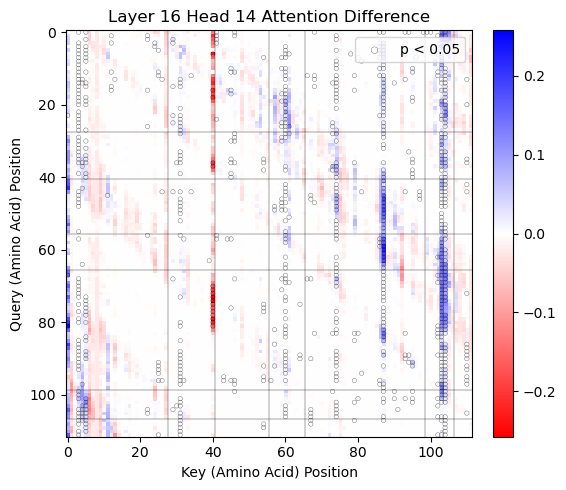

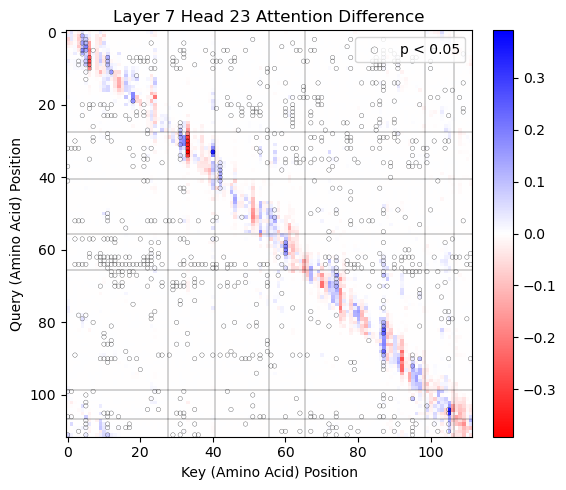

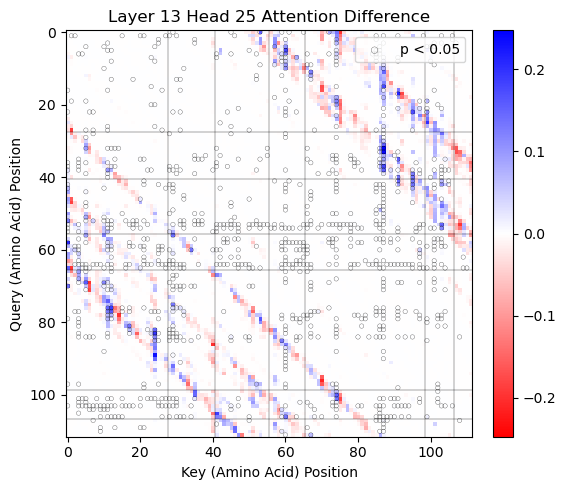

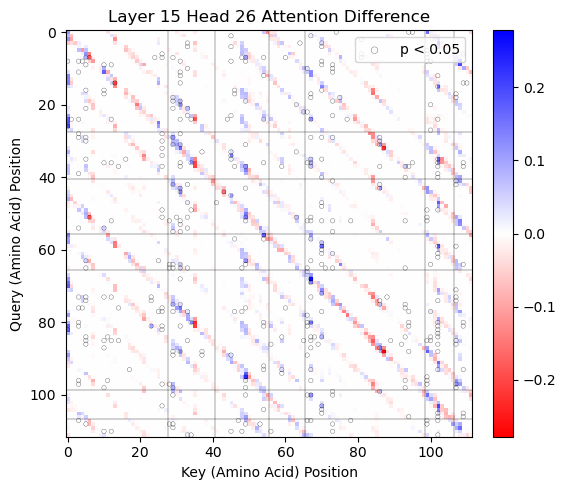

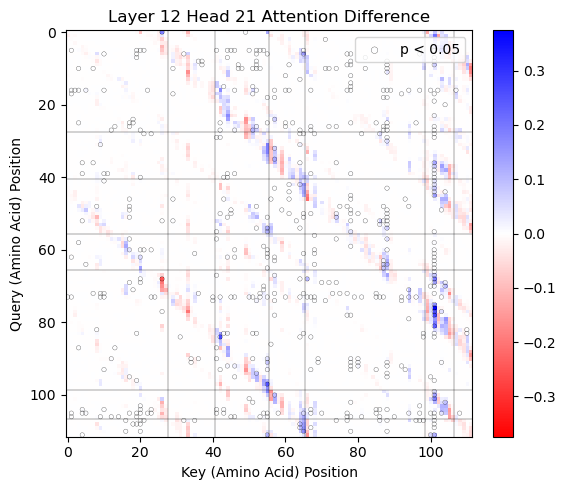

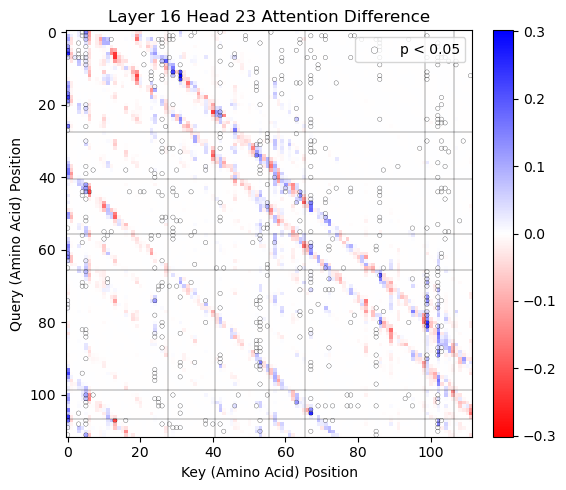

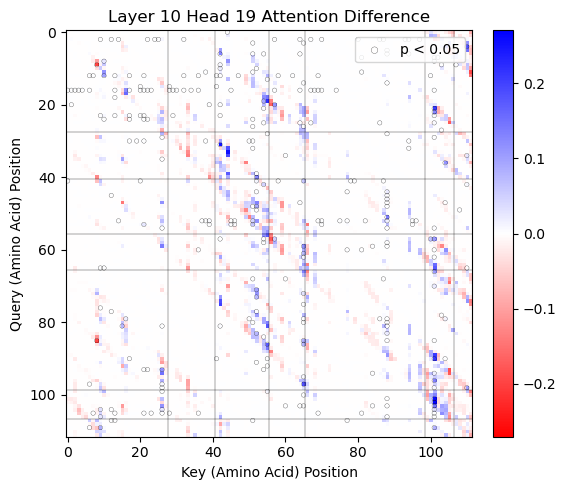

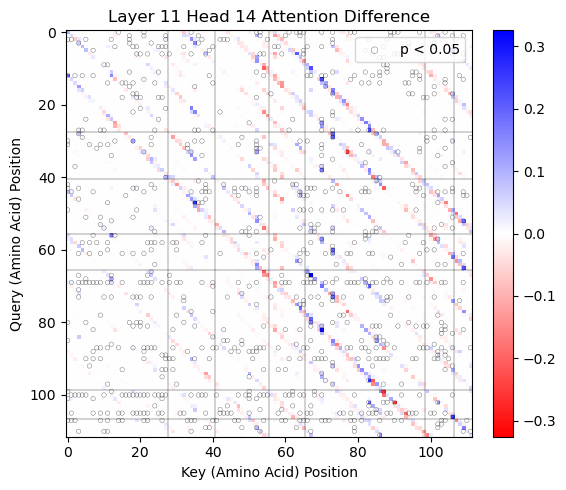

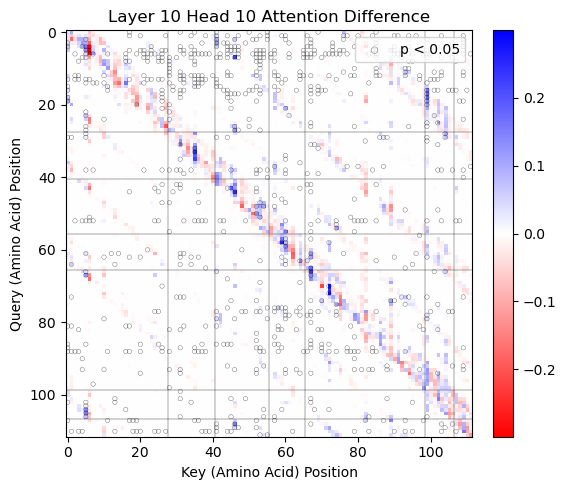

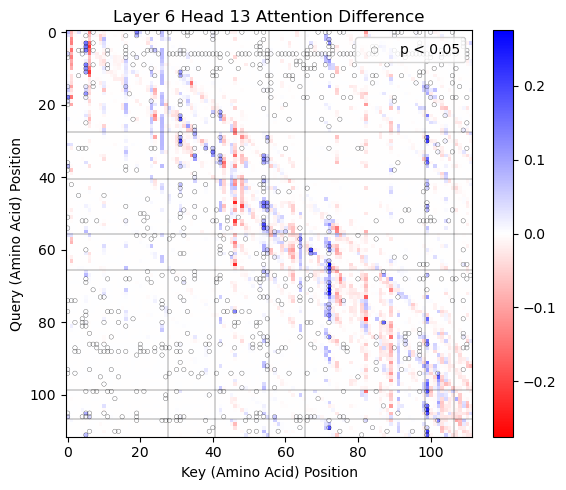

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# IMGT boundaries for heavy chain (0-based indexing):
# FR1: 0–25, CDR1: 26–38, FR2: 39–55, CDR2: 56–65, FR3: 66–104, CDR3: 105–111
IMGt_BOUNDS = [27, 40, 55, 65, 98, 106]
# IMGt_BOUNDS = [a+2 for a in IMGt_BOUNDS]


def plot_cropped_heatmap(
    mat: np.ndarray,
    title: str = None,
    cmap: str = "viridis",
    vmin: float = None,
    vmax: float = None
):
    """
    Crop to 112×112, draw IMGT boundaries, and plot.
    """
    crop = mat[:112, :112]
    # autoscale if not provided
    if vmin is None or vmax is None:
        vmax_val = np.nanmax(np.abs(crop))
        vmin, vmax = -vmax_val, vmax_val

    plt.figure(figsize=(6,5))
    im = plt.imshow(crop, aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    if title:
        plt.title(title)

    # overlay IMGT boundaries
    for b in IMGt_BOUNDS:
        # +0.5 to draw between pixels
        plt.axhline(b + 0.5, color='k', linewidth=1)
        plt.axvline(b + 0.5, color='k', linewidth=1)

    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.tight_layout()
    plt.show()


def plot_cropped_difference(
    diff_map: np.ndarray,
    sig_mask: np.ndarray,
    title: str = None
):
    # Crop
    diff_crop = diff_map[:112, :112]
    mask_crop = sig_mask[:112, :112]

    # symmetric color scale
    vmax = np.max(np.abs(diff_crop))
    vmin = -vmax

    plt.figure(figsize=(6,5))
    im = plt.imshow(diff_crop, cmap="bwr_r", vmin=vmin, vmax=vmax, aspect='equal')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    if title:
        plt.title(title)

    # Plot significance as hollow dots with a bit of transparency
    ys, xs = np.where(mask_crop)
    plt.scatter(
        xs, ys,
        s=10,
        facecolors='none',      # make them hollow
        edgecolors='k',         # black border
        linewidths=0.2,
        alpha=0.9,              # slight transparency
        label=f"p < {p_thresh}"
    )

    # IMGT boundaries
    for b in IMGt_BOUNDS:
        plt.axhline(b + 0.5, color='k', linewidth=0.25)
        plt.axvline(b + 0.5, color='k', linewidth=0.25)

    plt.legend(loc='upper right', markerscale=1.5)
    plt.xlabel("Key (Amino Acid) Position")
    plt.ylabel("Query (Amino Acid) Position")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# Example usage for your top‐5 heads:
# ----------------------------------------------------
for rank in range(10):
    head_idx = ranked_heads[rank]
    diff_map = diff.reshape(L*H, S, S)[head_idx]
    mask    = sig_mask.reshape(L*H, S, S)[head_idx]
    layer = head_idx//30 + 1
    head = head_idx%30+1
    plot_cropped_difference(
        diff_map.numpy(),
        mask,
        title=f"Layer {layer} Head {head} Attention Difference"
    )




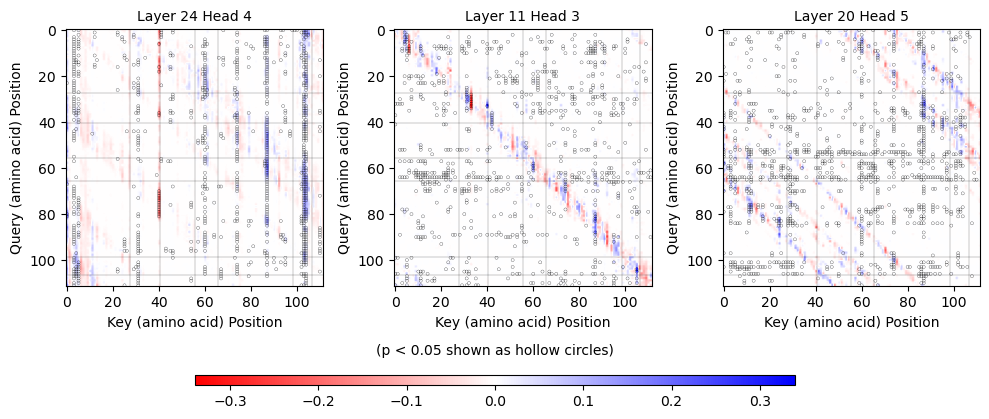

In [162]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # wider, less tall
axs = axs.flatten()

# Precompute global color scale across all heads for consistency
all_diff = diff.reshape(L * H, S, S)[580:600].numpy()
global_vmax = np.max(np.abs(all_diff))
global_vmin = -global_vmax

for i, head_idx in enumerate(ranked_heads[:3]):
    diff_map = diff.reshape(L * H, S, S)[head_idx].numpy()
    mask = sig_mask.reshape(L * H, S, S)[head_idx]
    layer = head_idx // 20 + 1
    head = head_idx % 20 + 1

    diff_crop = diff_map[:112, :112]
    mask_crop = mask[:112, :112]

    ax = axs[i]
    im = ax.imshow(
        diff_crop,
        cmap="bwr_r",
        vmin=global_vmin,
        vmax=global_vmax,
        aspect='equal'
    )

    ys, xs = np.where(mask_crop)
    ax.scatter(
        xs, ys,
        s=5,
        facecolors='none',
        edgecolors='k',
        linewidths=0.2,
        alpha=0.9,
        label=f"p < {p_thresh}"  # ← add label here
    )

    for b in IMGt_BOUNDS:
        ax.axhline(b + 0.5, color='k', linewidth=0.15)
        ax.axvline(b + 0.5, color='k', linewidth=0.15)

    ax.set_title(f"Layer {layer} Head {head}", fontsize=10)
    ax.set_xlabel("Key (amino acid) Position")
    ax.set_ylabel("Query (amino acid) Position")
    # ax.set_xticks()
    # ax.set_yticks()

    # ax.legend(loc='upper right', markerscale=1)

# Automatically tighten subplot layout
plt.tight_layout(rect=[0, 0.01, 1, 1])  # leave space at bottom for colorbar

# Add text box above the colorbar
fig.text(
    0.5, 0.12,  # x, y (centered, slightly above colorbar at 0.05)
    f'(p < {p_thresh} shown as hollow circles)',
    ha='center', va='center', fontsize=10
)

# Add horizontal colorbar below plots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.savefig('attentions.pdf', dpi=1000)

plt.show()



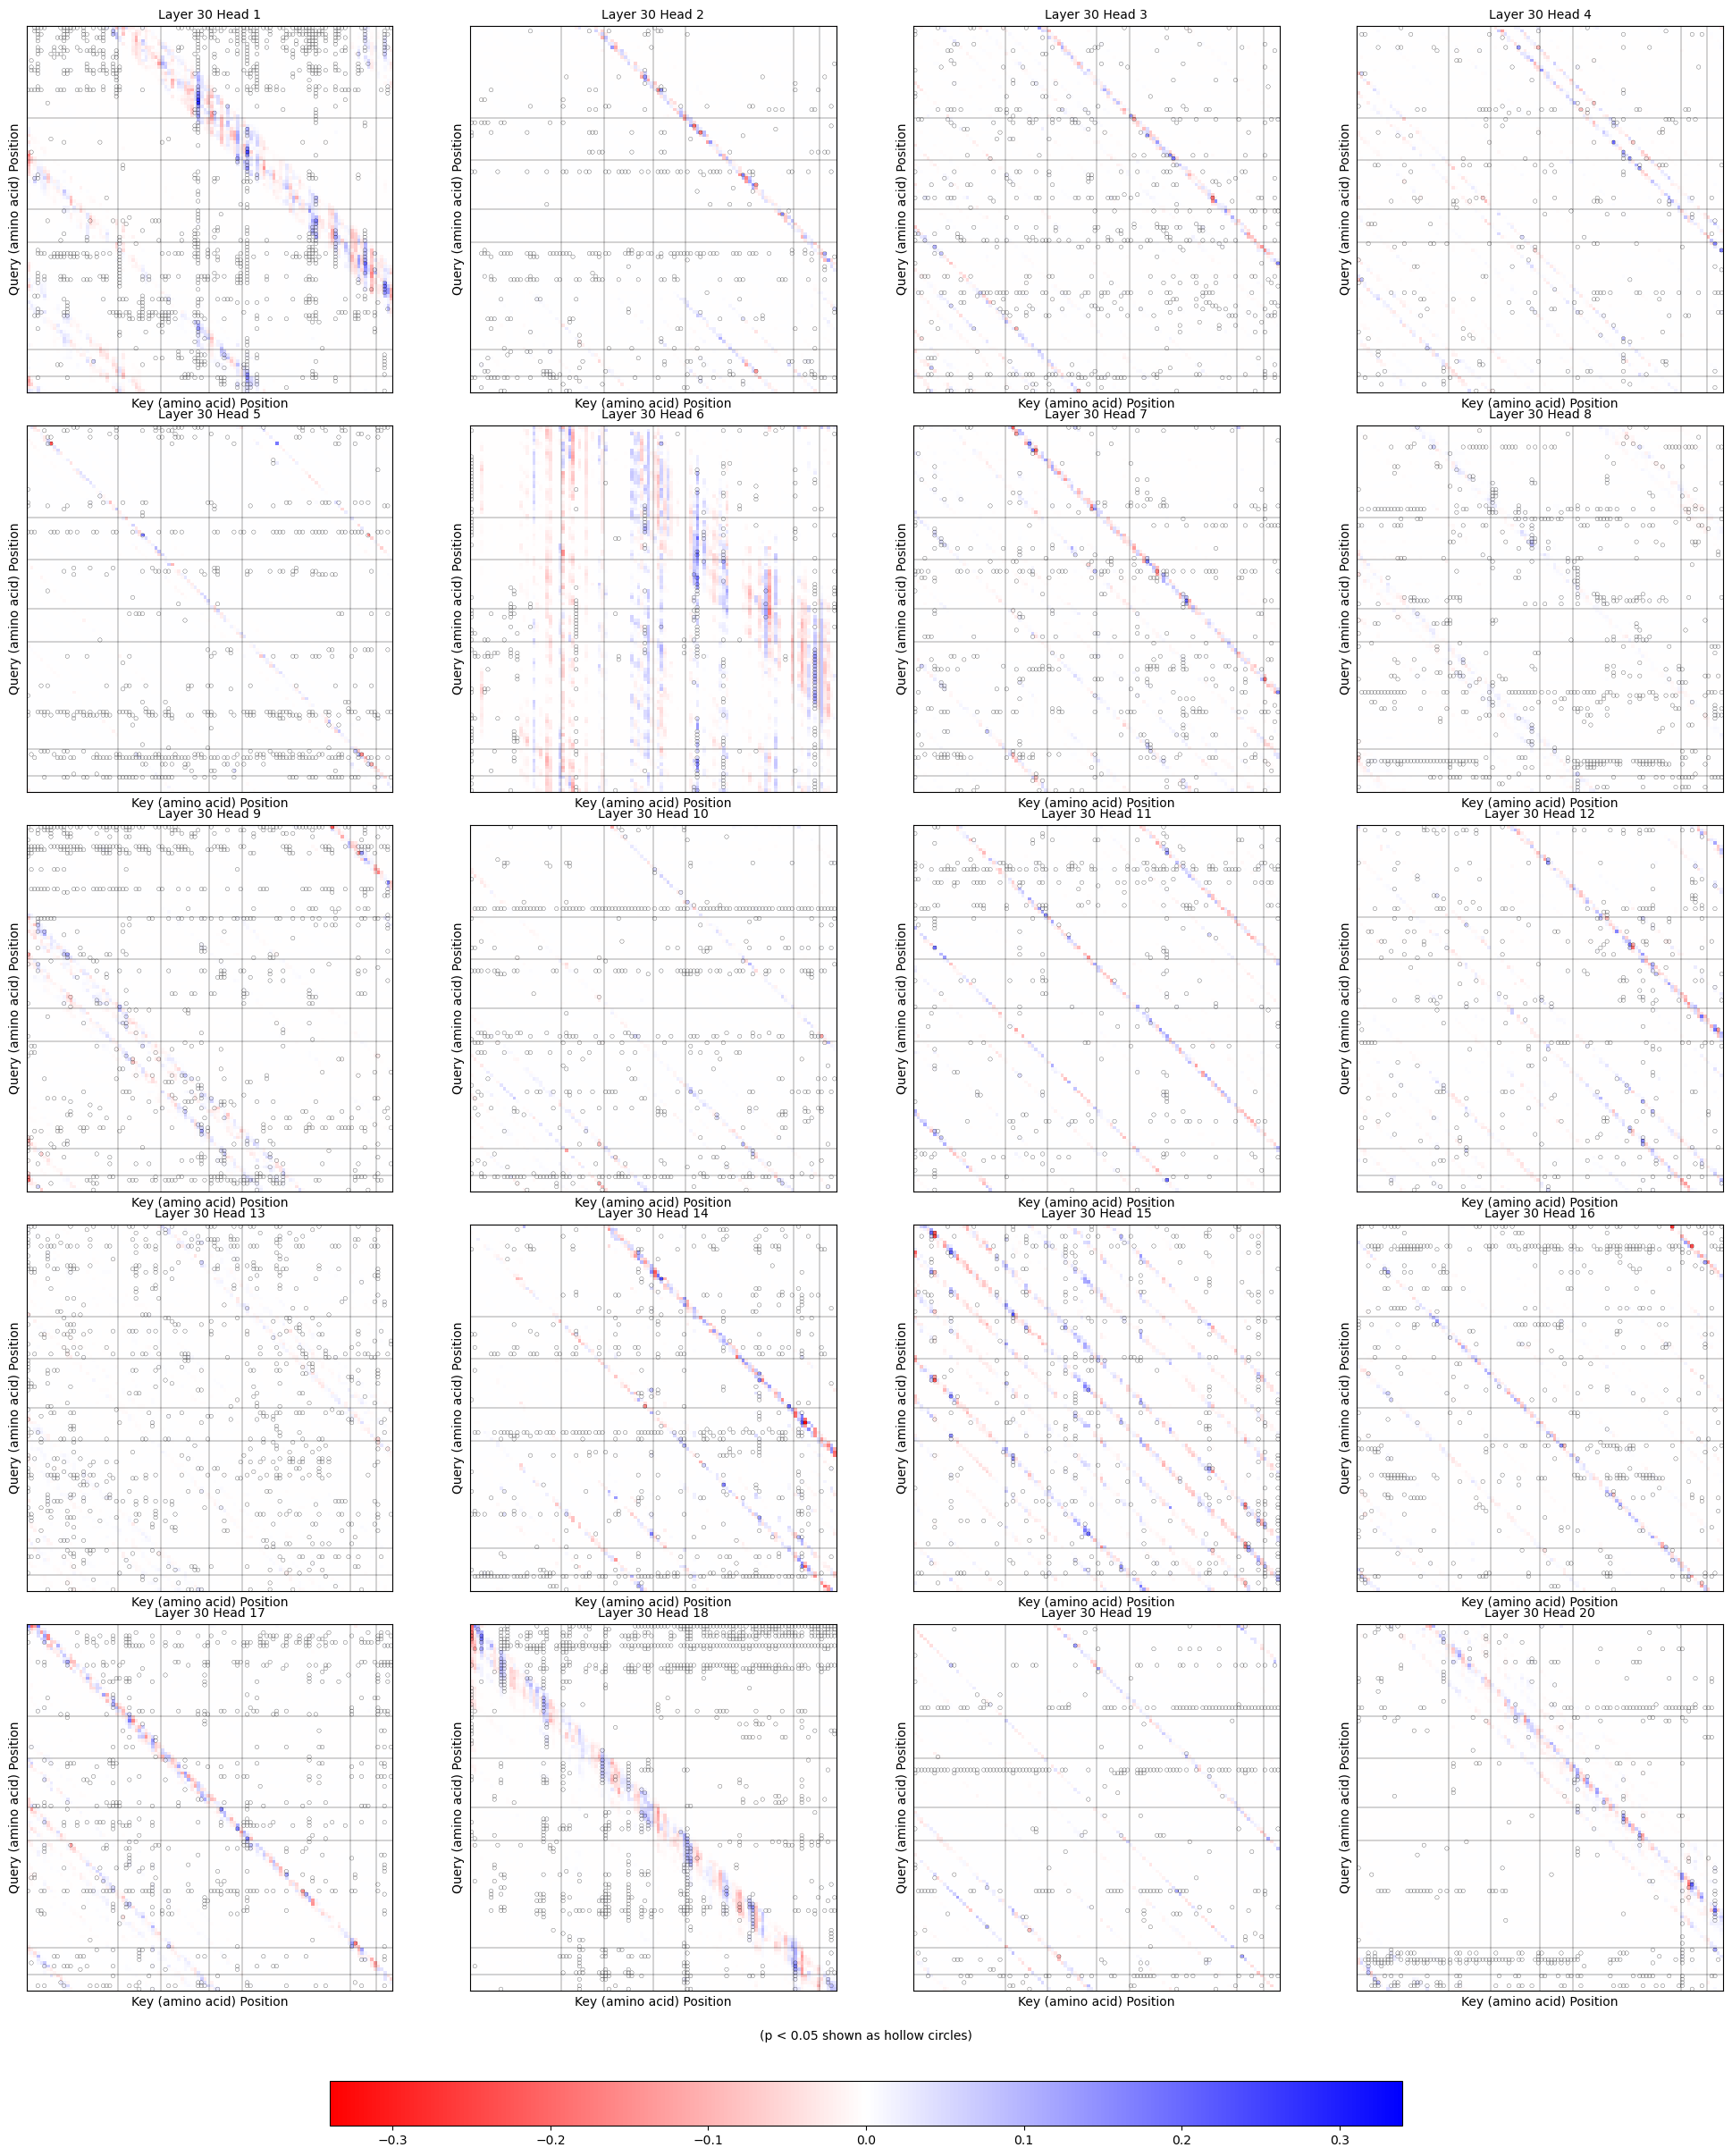

In [158]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(5, 4, figsize=(20, 25))
axs = axs.flatten()

# Precompute global color scale across all heads for consistency
all_diff = diff.reshape(L * H, S, S)[580:600].numpy()
global_vmax = np.max(np.abs(all_diff))
global_vmin = -global_vmax

for i, head_idx in enumerate(range(580, 600)):
    diff_map = diff.reshape(L * H, S, S)[head_idx].numpy()
    mask = sig_mask.reshape(L * H, S, S)[head_idx]
    layer = head_idx // 20 + 1
    head = head_idx % 20 + 1

    # Crop
    diff_crop = diff_map[:112, :112]
    mask_crop = mask[:112, :112]

    ax = axs[i]
    im = ax.imshow(
        diff_crop,
        cmap="bwr_r",
        vmin=global_vmin,
        vmax=global_vmax,
        aspect='equal'
    )

    # Plot significance as hollow dots
    ys, xs = np.where(mask_crop)
    ax.scatter(
        xs, ys,
        s=10,
        facecolors='none',
        edgecolors='k',
        linewidths=0.2,
        alpha=0.9
    )

    # IMGT boundaries
    for b in IMGt_BOUNDS:
        ax.axhline(b + 0.5, color='k', linewidth=0.25)
        ax.axvline(b + 0.5, color='k', linewidth=0.25)

    ax.set_title(f"Layer {layer} Head {head}", fontsize=10)
    ax.set_xlabel("Key (amino acid) Position")
    ax.set_ylabel("Query (amino acid) Position")
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout and make space for colorbar
plt.subplots_adjust(right=0.85)

# Automatically tighten subplot layout
plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for colorbar

# Add text box above the colorbar
fig.text(
    0.5, 0.09,  # x, y (centered, slightly above colorbar at 0.05)
    f'(p < {p_thresh} shown as hollow circles)',
    ha='center', va='center', fontsize=10
)

# Add horizontal colorbar below plots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.savefig('attentions_last_layer.pdf', dpi=1000)

plt.show()

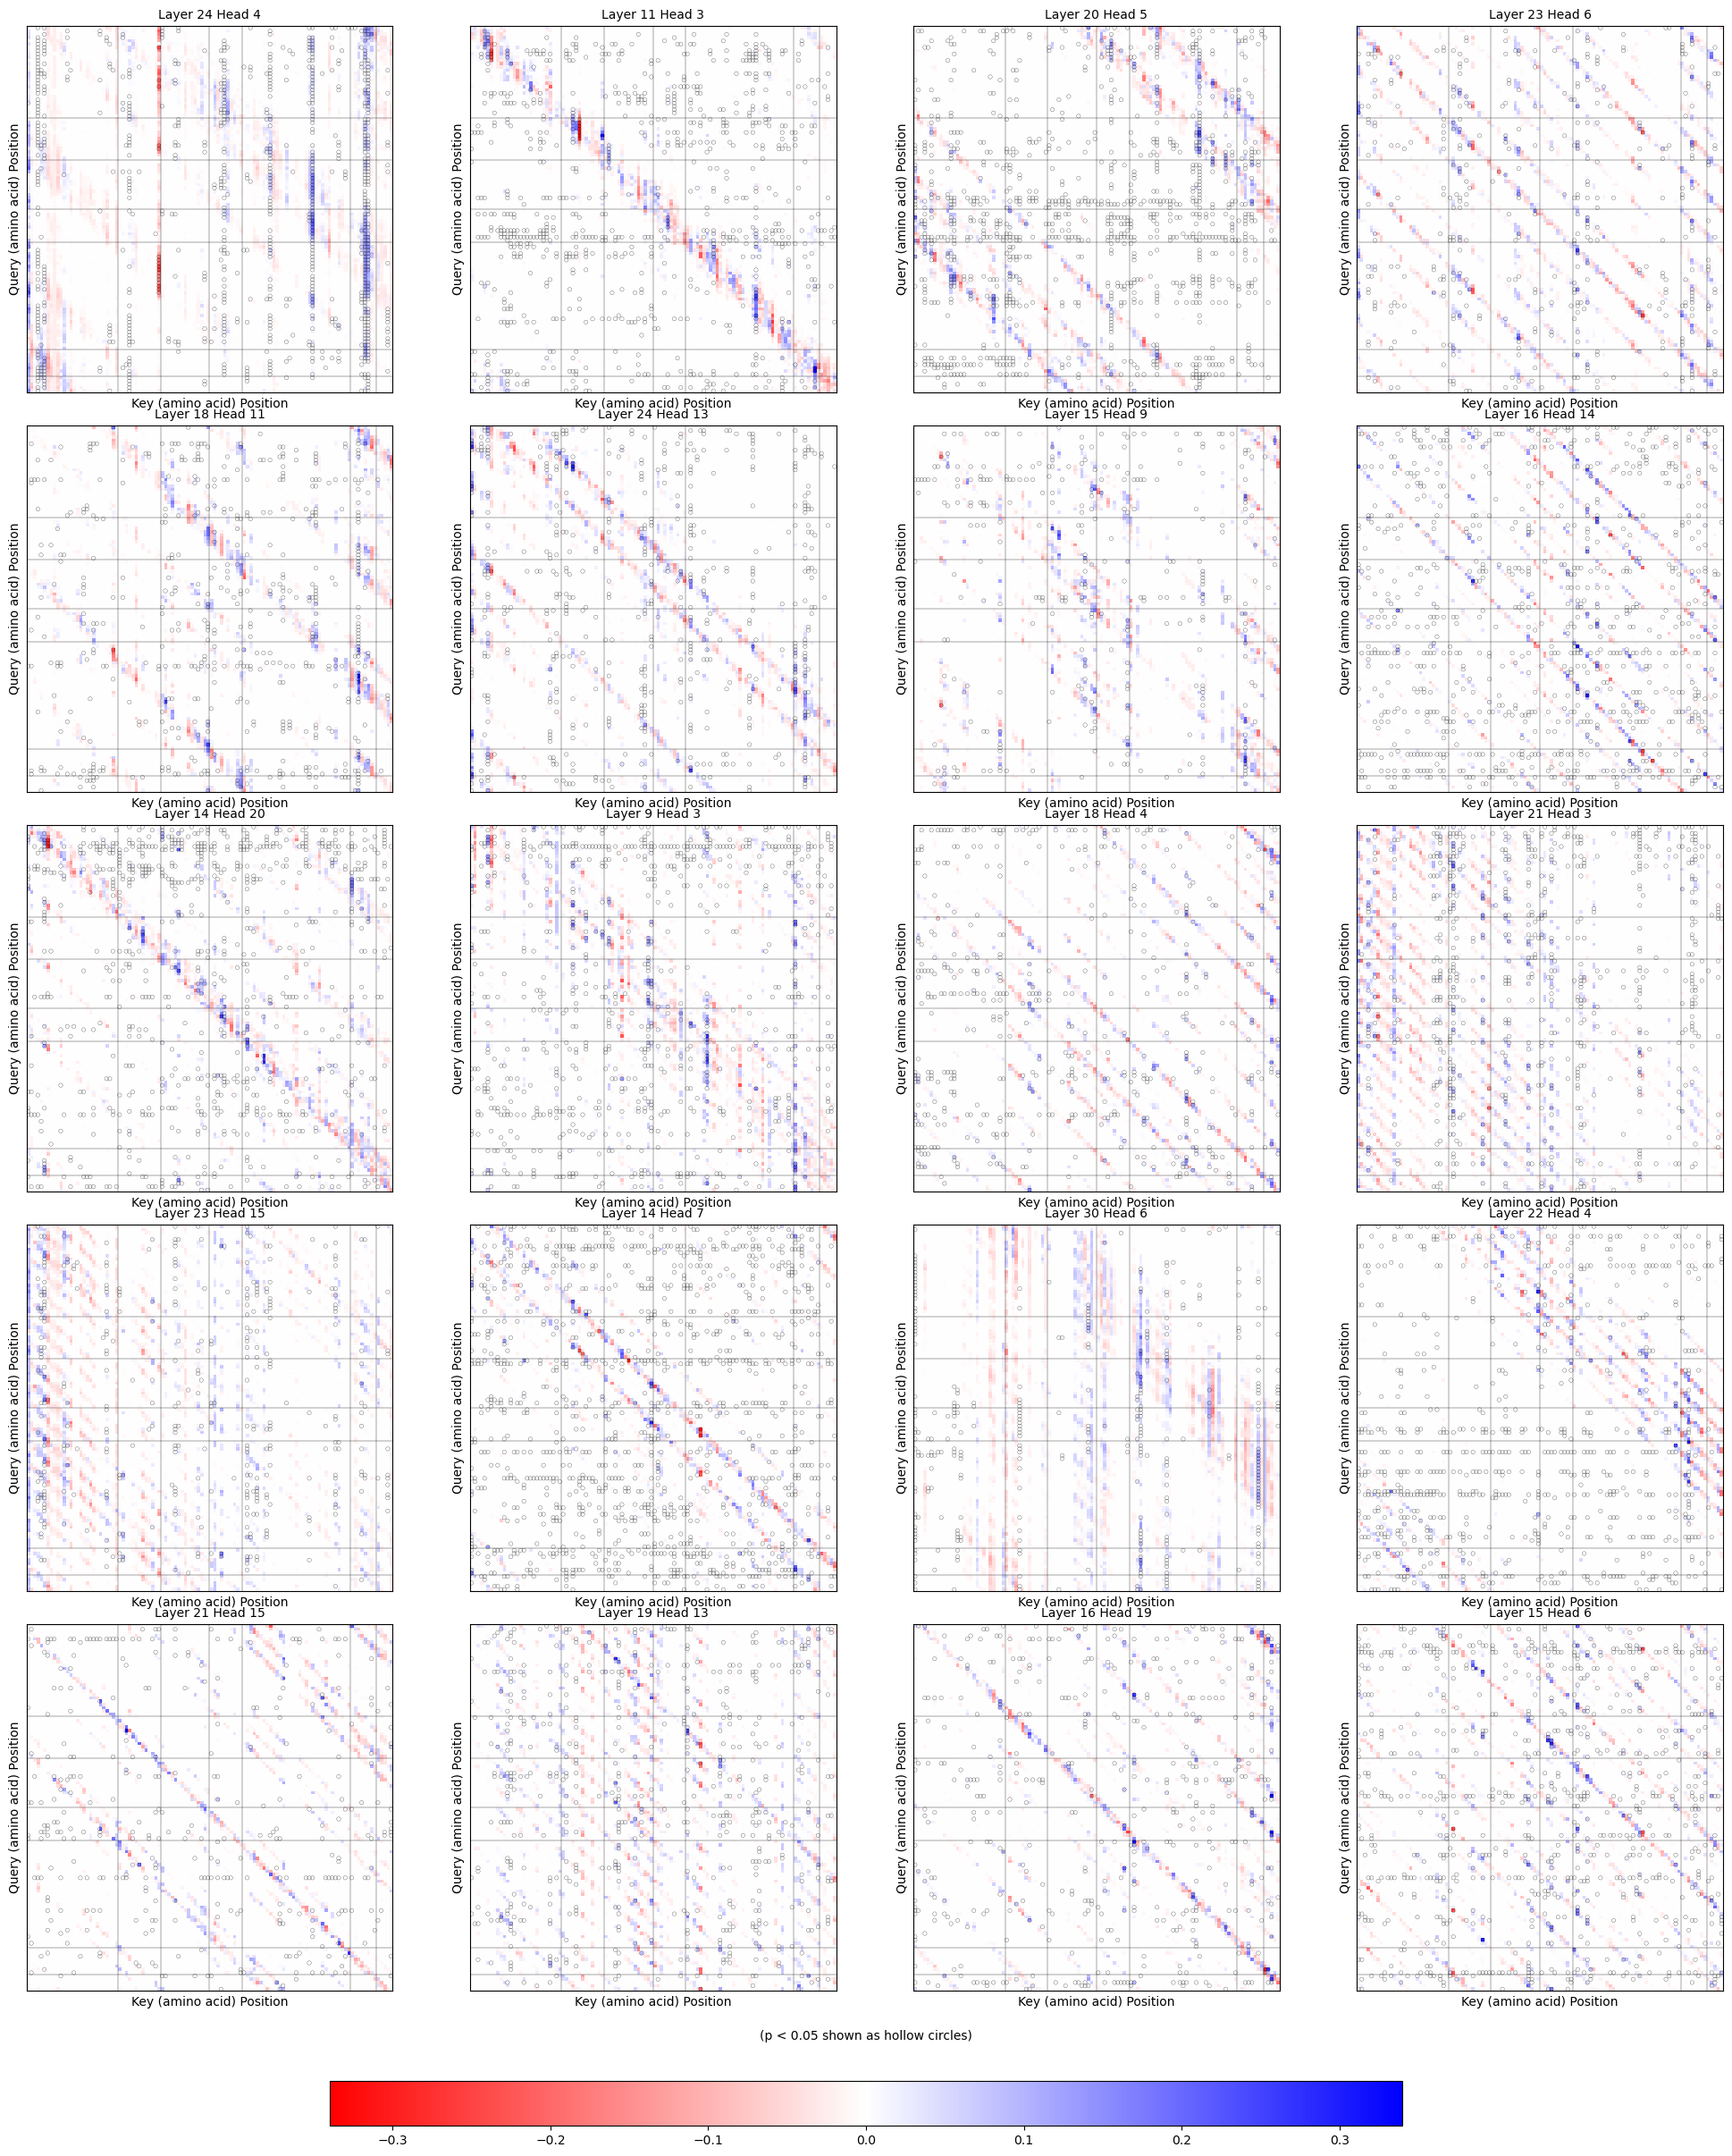

In [159]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(5, 4, figsize=(20, 25))
axs = axs.flatten()

# Precompute global color scale across all heads for consistency
all_diff = diff.reshape(L * H, S, S)[580:600].numpy()
global_vmax = np.max(np.abs(all_diff))
global_vmin = -global_vmax

for i, head_idx in enumerate(ranked_heads[:20]):
    diff_map = diff.reshape(L * H, S, S)[head_idx].numpy()
    mask = sig_mask.reshape(L * H, S, S)[head_idx]
    layer = head_idx // 20 + 1
    head = head_idx % 20 + 1

    # Crop
    diff_crop = diff_map[:112, :112]
    mask_crop = mask[:112, :112]

    ax = axs[i]
    im = ax.imshow(
        diff_crop,
        cmap="bwr_r",
        vmin=global_vmin,
        vmax=global_vmax,
        aspect='equal'
    )

    # Plot significance as hollow dots
    ys, xs = np.where(mask_crop)
    ax.scatter(
        xs, ys,
        s=10,
        facecolors='none',
        edgecolors='k',
        linewidths=0.2,
        alpha=0.9
    )

    # IMGT boundaries
    for b in IMGt_BOUNDS:
        ax.axhline(b + 0.5, color='k', linewidth=0.25)
        ax.axvline(b + 0.5, color='k', linewidth=0.25)

    ax.set_title(f"Layer {layer} Head {head}", fontsize=10)
    ax.set_xlabel("Key (amino acid) Position")
    ax.set_ylabel("Query (amino acid) Position")
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout and make space for colorbar
plt.subplots_adjust(right=0.85)

# Automatically tighten subplot layout
plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for colorbar

# Add text box above the colorbar
fig.text(
    0.5, 0.09,  # x, y (centered, slightly above colorbar at 0.05)
    f'(p < {p_thresh} shown as hollow circles)',
    ha='center', va='center', fontsize=10
)

# Add horizontal colorbar below plots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.savefig('attentions_top20_heads.pdf', dpi=1000)

plt.show()